In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
%%capture
from tqdm import notebook as nb_tqdm
nb_tqdm.tqdm().pandas()

In [2]:
# Fecthing private data
messages = pd.read_csv('databases/private-data/messages.csv')
orders = pd.read_csv('databases/private-data/order.csv')
sensors = pd.read_csv('databases/private-data/sensors.csv')

# Fetching public data
public = pd.read_csv('databases/public.csv')

In [3]:
#Analise do numero de voos FLIGHTS
mes_flight = messages[['FLIGHT']].copy()
mes_flight_uni = mes_flight['FLIGHT'].unique()
pub_flight = public[['FLIGHT']].copy()
pub_flight_uni = pub_flight['FLIGHT'].unique()
sens_flight = sensors[['FLIGHT']].copy()
sens_flight_uni = sens_flight['FLIGHT'].unique()

len(pub_flight_uni)
len(mes_flight_uni)
len(sens_flight_uni)

#Numero total de voos do DataBase = 1352
#Todos estao em sensors ou em flight_time_seriess

1352

In [4]:
#Criacao de um DataFrame para saber as ordens dos voos
i = 1
flight_time_series = pd.DataFrame()

flight_time_series = orders[orders['BEFORE'].isna()] 
df = flight_time_series.merge(orders,left_on='FLIGHT',right_on='BEFORE',how='inner')
flight_time_series.columns = ['FLIGHT_{}'.format(i), 'FLIGHT_{}'.format(i-1)]
flight_time_series = flight_time_series[['FLIGHT_{}'.format(i-1), 'FLIGHT_{}'.format(i)]]

sens_aux = sensors[['AC', 'FLIGHT']].copy()
sens_aux = sens_aux.drop_duplicates(subset=['FLIGHT'], keep='first')
flight_time_series = sens_aux.merge(flight_time_series,left_on='FLIGHT',right_on='FLIGHT_1',how='right')
flight_time_series.drop('FLIGHT_0',inplace=True,axis=1)
flight_time_series.drop('FLIGHT',inplace=True,axis=1)

while (len(df['FLIGHT_x']) > 0):
    i = i + 1
    flight_insert_df = pd.DataFrame()
    flight_insert_df = df[['FLIGHT_y', 'BEFORE_y']].copy()
    flight_insert_df.columns = ['FLIGHT','BEFORE']
    df = flight_insert_df.merge(orders,left_on='FLIGHT',right_on='BEFORE',how='inner')
    flight_time_series = flight_time_series.merge(flight_insert_df,left_on='FLIGHT_{}'.format(i-1),right_on='BEFORE',how='left')
    flight_time_series.drop('BEFORE',inplace=True,axis=1)
    flight_time_series.rename(columns = {'FLIGHT': 'FLIGHT_{}'.format(i)}, inplace=True)

#Maior numero de voos: 90

In [5]:
#Construção da DataFrame resumo do anterior
#Focando somente nos voos de Public
flight_time = pd.DataFrame()
FLIGHT = public['FLIGHT'].unique()
flight_time.insert(0,'FLIGHT',FLIGHT)
ORDER = pd.Series([])
for flight in FLIGHT:
    (row,col) = np.where(flight_time_series == flight)
    for i in range(len(flight_time)):
        if flight_time['FLIGHT'][i] == flight:
            ORDER[i] = int(col)
flight_time.insert(1,'ORDER',ORDER)
flight_time

/Users/alandias/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,FLIGHT,ORDER
0,00055a,9
1,006042,20
2,0192d1,35
3,01b892,5
4,01e2f1,29
...,...,...
896,fe8443,11
897,ff20aa,44
898,ff57d7,23
899,ff5b7a,28


In [12]:
flight_time = pd.DataFrame()
FLIGHT = sensors['FLIGHT'].unique()
flight_time.insert(0,'FLIGHT',FLIGHT)
ORDER = pd.Series([])
for flight in nb_tqdm.tqdm(FLIGHT):
    (row,col) = np.where(flight_time_series == flight)
    for i in range(len(flight_time)):
        if flight_time['FLIGHT'][i] == flight:
            ORDER[i] = int(col)
flight_time.insert(1,'ORDER',ORDER)
flight_time

/Users/alandias/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


,FLIGHT,ORDER
0,006042,20
1,03896c,40
2,03d505,38
3,04a6ea,26
4,05fd40,64
...,...,...
1347,f1d358,28
1348,f8348c,55
1349,fd6b6e,27
1350,fe38f6,36


In [13]:
flight_time.to_csv('flight_order_analysis.csv',index=False)

In [6]:
#Analisando os Sensors
flight_analysed = pd.DataFrame()
flight_analysed = sensors.merge(public,left_on='FLIGHT',right_on='FLIGHT',how='inner')
flight_analysed = flight_analysed.merge(flight_time,left_on='FLIGHT',right_on='FLIGHT',how='inner')
flight_analysed

,AC,FLIGHT,TIME,AMBIENT_1,PAR_AC_1,PAR_AC_2,PAR_AC_3,PAR_AC_4,PAR_SYS_1,PAR_SYS_2,...,PAR_SYS_9,PAR_SYS_10,PAR_SYS_5,WAR_SYS_2,PAR_SYS_6,WAR_SYS_3,PAR_SYS_7,PAR_SYS_8,MAINTENANCE,ORDER
0,AC19,006042,0,11720.0,44.18250,40.92875,0,0,69.000,285.0,...,0.0,0.0,1.0,0,1,0,225.7875,132.300,4,20
1,AC19,006042,1,11720.0,42.98375,40.07250,0,0,69.000,287.0,...,0.0,0.0,1.0,0,1,0,225.7875,132.300,4,20
2,AC19,006042,2,11720.5,42.98375,40.07250,0,0,69.000,287.0,...,0.0,0.0,1.0,0,1,0,112.7250,132.300,4,20
3,AC19,006042,3,11720.5,42.98375,40.07250,0,0,67.500,287.0,...,0.0,0.0,1.0,0,1,0,112.7250,124.875,4,20
4,AC19,006042,3060,11724.0,0.00000,0.00000,0,0,66.625,246.0,...,0.0,0.0,0.0,0,0,0,79.6500,0.000,4,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5486677,AC36,fe38f6,5799,12231.5,0.00000,0.00000,0,0,22.250,233.0,...,0.0,0.0,0.0,0,0,0,0.0000,0.000,10,36
5486678,AC36,fe38f6,5800,12231.5,0.00000,0.00000,0,0,22.250,232.0,...,0.0,0.0,0.0,0,0,0,0.0000,0.000,10,36
5486679,AC36,fe38f6,5801,12230.5,0.00000,0.00000,0,0,22.250,232.0,...,0.0,0.0,0.0,0,0,0,0.0000,0.000,10,36
5486680,AC36,fe38f6,5802,12231.5,0.00000,0.00000,0,0,22.250,232.0,...,0.0,0.0,0.0,0,0,0,0.0000,0.000,10,36


In [7]:
#Limpando dados de sensores
#Observa-se que todos em WAR_SYS_2 e WAR_SYS_3 dão resultao nulo. Dessa forma, retiraremos da análise
#flight_analysed[flight_analysed['WAR_SYS_2'] == 0]
#flight_analysed[flight_analysed['WAR_SYS_3'] == 0]
flight_analysed = flight_analysed.drop(columns = ['WAR_SYS_2','WAR_SYS_3'])
flight_analysed


,AC,FLIGHT,TIME,AMBIENT_1,PAR_AC_1,PAR_AC_2,PAR_AC_3,PAR_AC_4,PAR_SYS_1,PAR_SYS_2,...,WAR_SYS_1,COM_SYS_1,PAR_SYS_9,PAR_SYS_10,PAR_SYS_5,PAR_SYS_6,PAR_SYS_7,PAR_SYS_8,MAINTENANCE,ORDER
0,AC19,006042,0,11720.0,44.18250,40.92875,0,0,69.000,285.0,...,0,0,0.0,0.0,1.0,1,225.7875,132.300,4,20
1,AC19,006042,1,11720.0,42.98375,40.07250,0,0,69.000,287.0,...,0,0,0.0,0.0,1.0,1,225.7875,132.300,4,20
2,AC19,006042,2,11720.5,42.98375,40.07250,0,0,69.000,287.0,...,0,0,0.0,0.0,1.0,1,112.7250,132.300,4,20
3,AC19,006042,3,11720.5,42.98375,40.07250,0,0,67.500,287.0,...,0,0,0.0,0.0,1.0,1,112.7250,124.875,4,20
4,AC19,006042,3060,11724.0,0.00000,0.00000,0,0,66.625,246.0,...,0,0,0.0,0.0,0.0,0,79.6500,0.000,4,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5486677,AC36,fe38f6,5799,12231.5,0.00000,0.00000,0,0,22.250,233.0,...,0,0,0.0,0.0,0.0,0,0.0000,0.000,10,36
5486678,AC36,fe38f6,5800,12231.5,0.00000,0.00000,0,0,22.250,232.0,...,0,0,0.0,0.0,0.0,0,0.0000,0.000,10,36
5486679,AC36,fe38f6,5801,12230.5,0.00000,0.00000,0,0,22.250,232.0,...,0,0,0.0,0.0,0.0,0,0.0000,0.000,10,36
5486680,AC36,fe38f6,5802,12231.5,0.00000,0.00000,0,0,22.250,232.0,...,0,0,0.0,0.0,0.0,0,0.0000,0.000,10,36


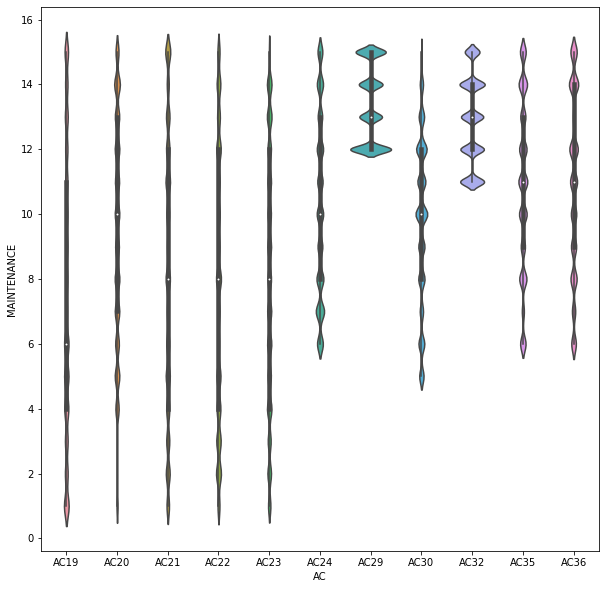

In [8]:
#Como se distribui a manutencao em relacao as aero
df_graph_01 = flight_analysed[['AC','MAINTENANCE']].copy()
df_graph_01
plt.figure(figsize=(10,10))
sns.violinplot(x = 'AC', y = 'MAINTENANCE',data=df_graph_01)

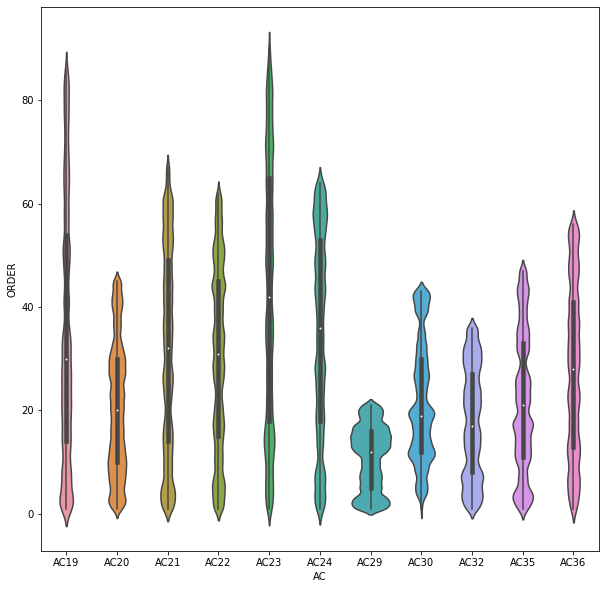

In [9]:
#Como se distribui as ordens em relacao as aero
df_graph_02 = flight_analysed[['AC','ORDER']].copy()
df_graph_02
plt.figure(figsize=(10,10))
sns.violinplot(x = 'AC', y = 'ORDER',data=df_graph_02)

<Figure size 720x720 with 0 Axes>

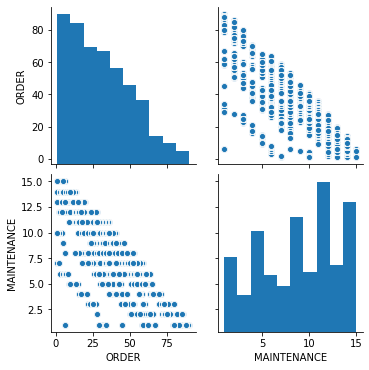

In [10]:
data_test = flight_analysed[['ORDER','MAINTENANCE']].copy()
plt.figure(figsize=(10,10))
sns.pairplot(data_test)